In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Path ke folder 'cropped_images' yang baru diunduh dan diekstrak
dataset_path = '/content/drive/MyDrive/Dataset_Skin_Tone/cropped_images_marcell/'

# Image dimensions
input_shape = (224, 224, 3)  # Mengubah ukuran input shape ke 224x224

# Define the classes
classes = ['putih', 'kuning', 'coklat', 'hitam']

# Hyperparameters
EPOCHS = 100
BS = 32

In [ ]:
# Load and preprocess the dataset
data = []
labels = []

In [ ]:
for idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=input_shape[:2])
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = tf.keras.applications.mobilenet_v3.preprocess_input(image)
        data.append(image)
        labels.append(idx)

In [ ]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
# Split the dataset into training and testing sets
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)


In [ ]:
# Data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
train_datagen = datagen.flow(trainX, trainY, batch_size=BS, shuffle=True)

In [ ]:
# Load the base model
base_model = MobileNetV3Small(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False  # Allow fine-tuning

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


# Add BatchNormalization layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.80),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Define callbacks
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
# Train the model
history = model.fit(
    train_datagen,
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping]
)


Epoch 1/100
9/9 [==============================] - 17s 1s/step - loss: 1.7915 - accuracy: 0.2972 - val_loss: 1.1480 - val_accuracy: 0.4745 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 9s 1s/step - loss: 1.2506 - accuracy: 0.5035 - val_loss: 1.0170 - val_accuracy: 0.5547 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 8s 833ms/step - loss: 1.2005 - accuracy: 0.5175 - val_loss: 0.8780 - val_accuracy: 0.6277 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 10s 1s/step - loss: 0.9676 - accuracy: 0.5559 - val_loss: 0.8330 - val_accuracy: 0.6642 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 9s 976ms/step - loss: 0.8904 - accuracy: 0.6154 - val_loss: 0.7673 - val_accuracy: 0.6861 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 7s 806ms/step - loss: 0.8622 - accuracy: 0.6329 - val_loss: 0.7302 - val_accuracy: 0.6788 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 10s 1s/step - loss: 0.7871 - acc

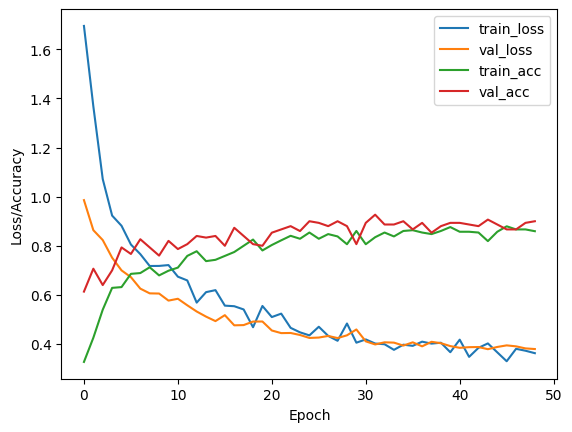

In [ ]:
# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.show()

In [ ]:
# Evaluate the model
preds = model.predict(testX)
y_pred = np.argmax(preds, axis=1)

# Confusion matrix and classification report
cm = confusion_matrix(testY, y_pred)
print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(classification_report(testY, y_pred, target_names=classes))

5/5 [==============================] - 2s 411ms/step
Confusion Matrix:
[[29  2  1  0]
 [ 3 26  1  0]
 [ 0  1 27  0]
 [ 0  1 12 34]]
Classification Report:
              precision    recall  f1-score   support

       putih       0.91      0.91      0.91        32
      kuning       0.87      0.87      0.87        30
      coklat       0.66      0.96      0.78        28
       hitam       1.00      0.72      0.84        47

    accuracy                           0.85       137
   macro avg       0.86      0.87      0.85       137
weighted avg       0.88      0.85      0.85       137



In [1]:
# # Save the model
# model.save('/content/drive/MyDrive/Dataset_Skin_Tone/modelb3.h5')
# print("Model saved.")

In [ ]:
from tensorflow.keras.models import load_model

# Path ke model yang disimpan
model_path = '/content/drive/MyDrive/Dataset_Skin_Tone/modelb4.h5'

# Memuat model
model = load_model(model_path)


In [ ]:
# Initialize the TFLiteConverter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: Apply optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('/content/drive/MyDrive/Dataset_Skin_Tone/modelb4.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.3 MB/s eta 0:00:00


1/1 [==============================] - 1s 946ms/step


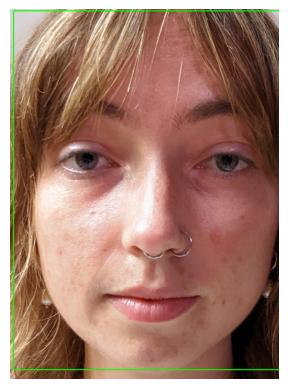

1/1 [==============================] - 0s 34ms/step


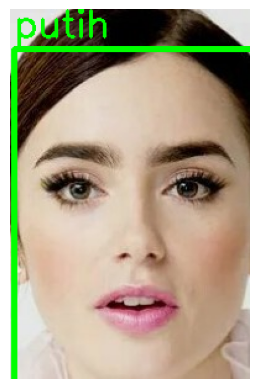

1/1 [==============================] - 0s 33ms/step


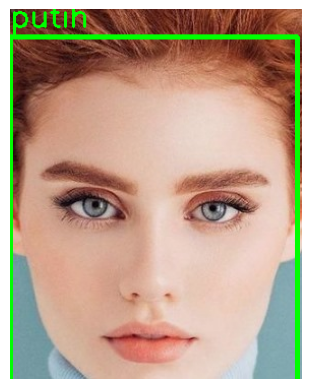

1/1 [==============================] - 0s 52ms/step


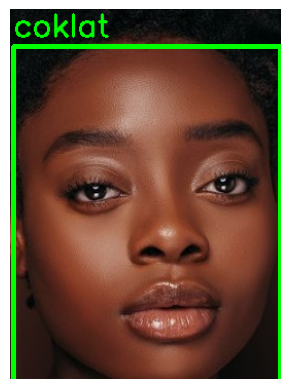

1/1 [==============================] - 0s 66ms/step


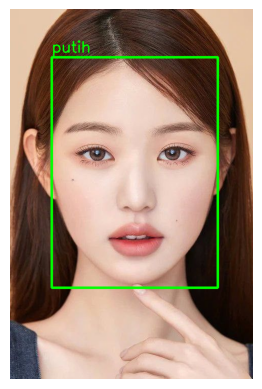

In [ ]:
import os
import cv2
import numpy as np
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Inisialisasi MTCNN
mtcnn = MTCNN()

# Memuat model yang telah dilatih
model_path ='/content/drive/MyDrive/Dataset_Skin_Tone/modela85va89.h5'
model = load_model(model_path)

# Direktori sumber gambar
source_folder = '/content/drive/MyDrive/Dataset_Skin_Tone/test'
# Direktori tujuan untuk menyimpan gambar yang sudah dipotong
destination_folder = '/content/drive/MyDrive/Dataset_Skin_Tone/test_hasil'
# Membuat folder tujuan jika belum ada
os.makedirs(destination_folder, exist_ok=True)

# Daftar kelas
classes = ['putih', 'kuning', 'coklat', 'hitam']

# Fungsi untuk memproses gambar dalam folder
## Fungsi untuk memproses gambar dalam folder
def process_images(source_folder, destination_folder):
    for filename in os.listdir(source_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(source_folder, filename)
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Deteksi wajah
            faces = mtcnn.detect_faces(image_rgb)

            if faces:
                # Ambil wajah pertama yang terdeteksi
                face = faces[0]
                x, y, width, height = face['box']
                # Memotong gambar sesuai bounding box
                cropped_face = image[y:y+height, x:x+width]

                # Menyimpan gambar hasil potongan
                cropped_face_filename = f"{os.path.splitext(filename)[0]}_face.jpg"
                cropped_face_path = os.path.join(destination_folder, cropped_face_filename)
                cv2.imwrite(cropped_face_path, cropped_face)

                # Proses prediksi skin tone
                face_rgb = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)
                face_resized = cv2.resize(face_rgb, (224, 224))
                face_array = img_to_array(face_resized)
                face_array = np.expand_dims(face_array, axis=0)
                face_array = tf.keras.applications.mobilenet_v3.preprocess_input(face_array)

                # Prediksi kelas skin tone
                prediction = model.predict(face_array)
                predicted_class = classes[np.argmax(prediction)]

                # Gambar bounding box di sekitar wajah yang terdeteksi untuk visualisasi
                cv2.rectangle(image_rgb, (x, y), (x + width, y + height), (0, 255, 0), 4)
                cv2.putText(image_rgb, predicted_class, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                # Menyimpan gambar dengan bounding box dan prediksi
                result_image_filename = f"{os.path.splitext(filename)[0]}_{predicted_class}_result.jpg"
                result_image_path = os.path.join(destination_folder, result_image_filename)
                image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving
                cv2.imwrite(result_image_path, image_bgr)

                # Tampilkan gambar dengan bounding box dan prediksi
                plt.imshow(image_rgb)
                plt.axis('off')
                plt.show()
# Memproses gambar dalam folder
process_images(source_folder, destination_folder)